# 1. Install Necessary Libraries

In [67]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain-community langchain-openai tavily-python

# 2. Import necessary dependencies and set environment variables

In [68]:
import os
import getpass

from langchain_openai import ChatOpenAI

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")


In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini")

# Agentic System

An Agentic System, in the context of AI, refers to a system where one or more Agents are involved. These agents are not just passive entities that respond to commands but exhibit characteristics like:

Autonomy: They can act independently and make decisions.

Proactiveness: They can initiate actions and pursue goals.

Adaptability: They can learn and adapt to changes in their environment.

Goal-Oriented Behavior: They strive to achieve specific objectives or fulfill a particular purpose.

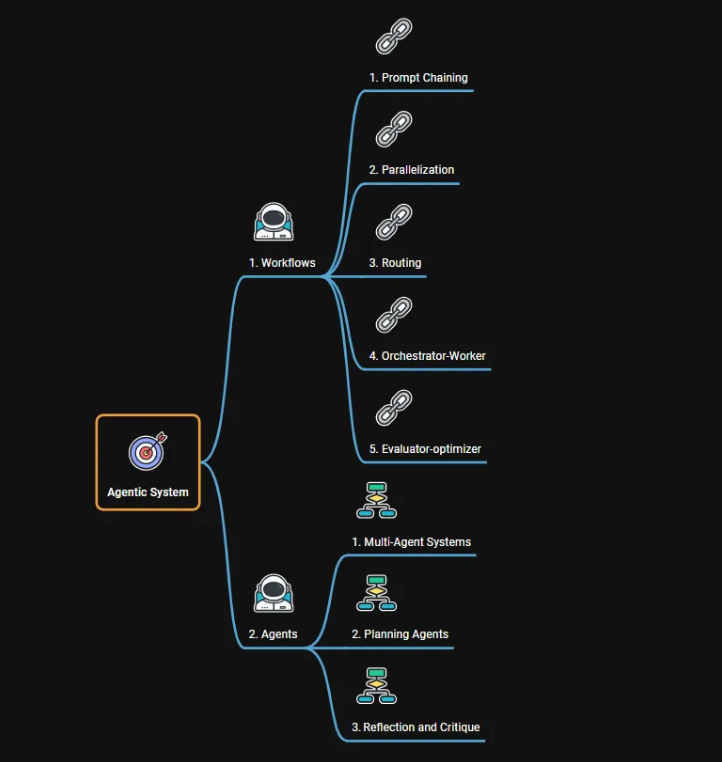

Detailed Blog : https://aiproductplaybook.substack.com/p/101-what-the-heck-are-agentic-system

# 3. # 3. Agents - Reflection and Critique (Basic Reflection)

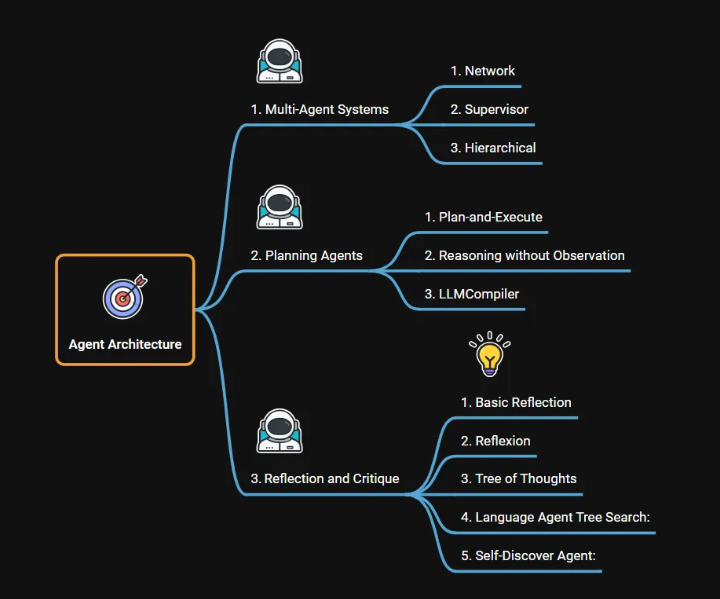

Detailed Blog : https://aiproductplaybook.substack.com/p/what-the-heck-are-reflections-in

a. Basic Reflection

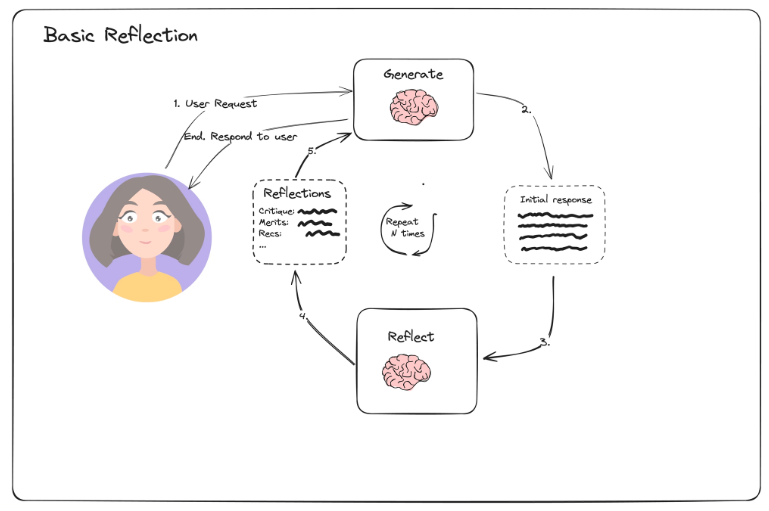

### b. Define the langchain pipeline for essay generation

This code defines a LangChain pipeline for generating essays. It uses a prompt template to instruct the LLM and a placeholder to manage conversation history. The pipeline makes it easy to generate an initial essay and then refine it based on user critique.

In [69]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an essay assistant tasked with writing excellent 5-paragraph essays."
            " Generate the best essay possible for the user's request."
            " If the user provides critique, respond with a revised version of your previous attempts.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
llm = ChatOpenAI(
    model="gpt-4o-mini", max_tokens=10000
)
generate = prompt | llm


In [70]:
essay = ""
request = HumanMessage(
    content="Write an essay on why the little prince is relevant in modern childhood"
)
for chunk in generate.stream({"messages": [request]}):
    print(chunk.content, end="")
    essay += chunk.content

**The Relevance of "The Little Prince" in Modern Childhood**

Antoine de Saint-Exupéry's "The Little Prince," first published in 1943, is a timeless tale that continues to resonate with readers of all ages, but particularly with children. The story, which explores themes of innocence, love, and the importance of seeing beyond the surface, holds significant relevance in the landscape of modern childhood. In an age dominated by technology, materialism, and fast-paced lifestyles, "The Little Prince" offers valuable lessons that promote emotional intelligence, imagination, and a deeper understanding of human connections.

Firstly, "The Little Prince" encourages emotional intelligence in children, an essential attribute in today's society. The protagonist, a young prince from a distant asteroid, embarks on a journey that allows him to encounter various characters, each representing different attitudes and values. Through these encounters, young readers learn the significance of empathy and 

### c. LangChain pipeline for generating feedback or critique on an essay submission

In [71]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a teacher grading an essay submission. Generate critique and recommendations for the user's submission."
            " Provide detailed recommendations, including requests for length, depth, style, etc.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
reflect = reflection_prompt | llm

In [72]:
reflection = ""
for chunk in reflect.stream({"messages": [request, HumanMessage(content=essay)]}):
    print(chunk.content, end="")
    reflection += chunk.content

**Critique and Recommendations for Your Essay on "The Little Prince"**

Your essay on the relevance of *The Little Prince* in modern childhood presents a thoughtful exploration of its themes and their importance in contemporary society. Overall, you've done an admirable job of articulating key ideas that support your thesis. However, there are several areas where you could enhance your essay’s depth, clarity, and engagement with the reader.

### Strengths:
1. **Thesis Clarity**: Your thesis clearly states the relevance of the book to modern childhood, and you articulate specific themes that support this argument.
2. **Theme Exploration**: You did well to identify themes such as emotional intelligence, imagination, and the critique of materialism. Each theme is accompanied by relevant examples from the text.

### Areas for Improvement:

1. **Depth of Analysis**: 
   - While you touched on critical themes, consider deepening your analysis by exploring how these themes specifically impact

### d. Repeat

The code sends the initial request, the previous essay, and the feedback to the generate pipeline. The pipeline, as defined previously, uses a prompt template and the LLM to generate a revised essay that takes into account the previous draft and the feedback.  Because stream() is used, the revised essay is printed chunk by chunk as it's generated, which is more efficient and provides a better user experience, especially for long essays.

In [ ]:
for chunk in generate.stream(
    {"messages": [request, AIMessage(content=essay), HumanMessage(content=reflection)]}
):
    print(chunk.content, end="")

### e. Define the LangChain Graph

1. Import necessary dependencies

2. State TypedDict

a. Defines a State TypedDict, which is a typed dictionary used to store the state of the conversation.

b. messages: Annotated[list, add_messages]: Specifies that the messages key will hold a list of messages. The Annotated type hint with add_messages suggests that a custom function (or special handling) is used to add messages to this list, possibly for managing conversation history efficiently.

3. generation_node(state: State) Function

a. This function defines the "generation" node in the graph.

b. It takes the current state as input.

c. await generate.ainvoke(state["messages"]): Asynchronously calls the generate function (defined elsewhere, likely the essay generation pipeline from your previous code). It passes the current list of messages from the state to the generate pipeline.

d. It returns a new state dictionary with the updated messages list. The output of the generate call (the new essay draft) is appended to the message history.

4. reflection_node(state: State) Function

a. This function defines the "reflection" node.

b. It takes the current state as input.

c. cls_map = {"ai": HumanMessage, "human": AIMessage}: Creates a mapping to reverse the message types. This is because the reflect prompt expects the previous AI message (the essay draft) to be a human message (from the essay writer's perspective), and the previous human message (the feedback) to be an AI message (from the teacher's perspective).

d. translated = ...: This line translates the message types. The first message (the original user request) is kept as is. Subsequent messages are converted: AI messages become Human messages, and Human messages become AI messages.

e. res = await reflect.ainvoke(translated): Asynchronously calls the reflect function (the feedback generation pipeline). It passes the translated list of messages.

f. It returns a new state dictionary with the feedback from reflect as a new HumanMessage.

5. Building the Graph

6. should_continue(state: State) Function

a. This function determines the next node to execute based on the current state.

b. if len(state["messages"]) > 6:: Checks if the number of messages in the state is greater than 6. This acts as a limit for the number of iterations (generations and reflections). Since each iteration adds two messages (one AI essay and one Human reflection), this effectively limits the process to 3 iterations.

c. If the message limit is reached, it returns END, stopping the graph execution.

d. Otherwise, it returns "reflect", indicating that the next node to execute is the "reflect" node.

7. Adding Conditional Edges and Compiling

a. builder.add_conditional_edges("generate", should_continue): Adds a conditional edge from the "generate" node. The should_continue function determines the next node.

b. builder.add_edge("reflect", "generate"): Adds an edge from "reflect" back to "generate", creating the loop for iterative refinement.

c. memory = MemorySaver(): Creates a MemorySaver object to store the graph state in memory. This is important for keeping track of the conversation history across iterations.

d. graph = builder.compile(checkpointer=memory): Compiles the graph, creating an executable graph object.

Summary

This code defines a LangChain graph for iterative essay generation and feedback. The graph starts with a "generate" node, which creates an essay.  Then, the "reflect" node provides feedback. The graph loops between these two nodes until a maximum of 3 iterations (6 messages) is reached. The should_continue function controls the flow of the graph, and the MemorySaver ensures that the conversation history is preserved across iterations. This setup allows for automated essay revision based on feedback.

In [73]:
from typing import Annotated, List, Sequence
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]


async def generation_node(state: State) -> State:
    return {"messages": [await generate.ainvoke(state["messages"])]}


async def reflection_node(state: State) -> State:
    # Other messages we need to adjust
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    # First message is the original user request. We hold it the same for all nodes
    translated = [state["messages"][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state["messages"][1:]
    ]
    res = await reflect.ainvoke(translated)
    # We treat the output of this as human feedback for the generator
    return {"messages": [HumanMessage(content=res.content)]}


builder = StateGraph(State)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_edge(START, "generate")


def should_continue(state: State):
    if len(state["messages"]) > 6:
        # End after 3 iterations
        return END
    return "reflect"


builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

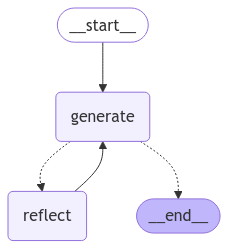

In [74]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### f. Invoke the Agentic System

In [75]:
config = {"configurable": {"thread_id": "1"}}

async for event in graph.astream(
    {
        "messages": [
            HumanMessage(
                content="Generate an essay on the topicality of The Little Prince and its message in modern life"
            )
        ],
    },
    config,
):
    print(event)
    print("---")

{'generate': {'messages': [AIMessage(content='**The Timeless Relevance of "The Little Prince" in Contemporary Life**\n\nAntoine de Saint-Exupéry\'s novella "The Little Prince," first published in 1943, is not merely a children\'s story but a profound exploration of human nature, love, and the essence of childhood. Its themes of innocence, friendship, and the critique of adult behavior resonate deeply in our modern society, where materialism, disconnection, and the frantic pace of life often overshadow the values of empathy and imagination. As we navigate the complexities of contemporary existence, the messages embedded in "The Little Prince" remain startlingly relevant, urging us to reconsider our priorities and rediscover the cherished qualities of our youth.\n\nOne of the central themes of "The Little Prince" is the importance of looking beyond the surface to grasp the deeper meanings of relationships and experiences. The titular character encapsulates the essence of seeing with the 

In [76]:
state = graph.get_state(config)
ChatPromptTemplate.from_messages(state.values["messages"]).pretty_print()

================================ Human Message =================================

Generate an essay on the topicality of The Little Prince and its message in modern life

================================== Ai Message ==================================

**The Timeless Relevance of "The Little Prince" in Contemporary Life**

Antoine de Saint-Exupéry's novella "The Little Prince," first published in 1943, is not merely a children's story but a profound exploration of human nature, love, and the essence of childhood. Its themes of innocence, friendship, and the critique of adult behavior resonate deeply in our modern society, where materialism, disconnection, and the frantic pace of life often overshadow the values of empathy and imagination. As we navigate the complexities of contemporary existence, the messages embedded in "The Little Prince" remain startlingly relevant, urging us to reconsider our priorities and rediscover the cherished qualities of our youth.

One of the central themes